# **U-Net Model for Brain MRI Segmentation**

---



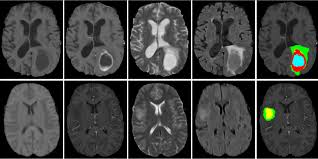

This code implements a U-Net architecture for segmenting brain MRI images into different regions. It covers various aspects of the segmentation task, including data preparation, U-Net model architecture, custom loss functions and metrics, data augmentation, training, result visualization, and model evaluation. The U-Net model is trained on a dataset of brain MRI images and masks, and its performance is evaluated using metrics such as loss, Intersection over Union (IOU), and Dice Coefficient. The code also includes visualization of original images, original masks, and the model's predicted masks for a selection of test images.






# 1. Download dataset using opendatasets library

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?datasetId=181273&sortBy=voteCount'

In [2]:
%%time
od.download(dataset_url)

100%|██████████| 714M/714M [00:33<00:00, 22.5MB/s]



CPU times: user 15.9 s, sys: 4.58 s, total: 20.5 s
Wall time: 55 s


In [3]:
data_dir = '/content/lgg-mri-segmentation'

# Import Libraries

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 3. Preparing the dataset

In [5]:
#setting desired width and height of the images in pixels.
img_width = 256
img_height = 256

In [6]:
train_files = [] #lists that will store the file paths of the training images and their corresponding masks.
mask_files = glob('../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
for i in mask_files:
  train_files.append(i.replace('_mask', ''))

print(train_files[:10])
print(mask_files[:10])

['../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_7.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_10.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_23.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_17.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_5.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_3.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_21.tif', '../content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCG

# 4. Display original images along with their corresponding masks

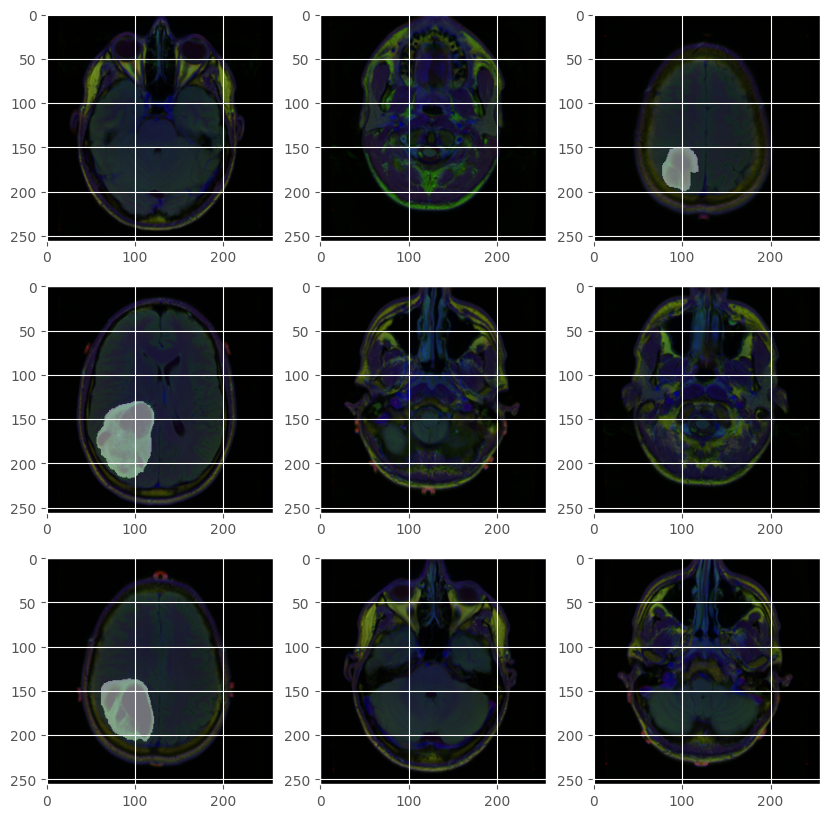

In [7]:
rows, cols =3,3
fig = plt.figure(figsize=(10,10))
for i in range(1, rows*cols+1):
  fig.add_subplot(rows, cols,i)
  img_path=train_files[i]
  msk_path=mask_files[i]
  img=cv2.imread(img_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  msk=cv2.imread(msk_path)
  plt.imshow(img)
  plt.imshow(msk, alpha=0.4)

plt.show()

# 5. Splitting Dataset into train,test and split

In [8]:
df=pd.DataFrame(data={"filename": train_files, 'mask':mask_files})
df_train, df_test  = train_test_split(df, test_size =0.1)
df_train, df_val = train_test_split(df_train, test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


# 6. Define a data generator function for training a neural network on image segmentation tasks.

The generator generates pairs of images and their corresponding masks, applies data augmentation, and prepares the data for model training.

This generator function is designed to provide preprocessed image-mask pairs with data augmentation to train a neural network for image segmentation tasks, like the U-Net architecture used in medical image segmentation.

### **what is a generator?**


In Python, a generator is a special type of iterator that allows you to iterate over a sequence of values while generating each value on-the-fly, rather than creating the entire sequence in memory. This is particularly useful when dealing with large datasets or when you want to create values on-the-fly based on some computation or logic. Generators provide a memory-efficient way to work with sequences of data.

In [9]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask): ## performs the preprocessing on the images and masks
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

# 7. Define loss and metrics

## Dice coefficient:
dice_coef(y_true, y_pred):

This function calculates the Dice coefficient between the ground truth mask (y_true) and the predicted mask (y_pred) for binary image segmentation. The Dice coefficient is a measure of the overlap between two sets. It's commonly used to evaluate the similarity between the predicted and true segmentations.

### what is segmentation ?

Image segmentation is a computer vision task that involves dividing an image into different segments or regions, each of which corresponds to a meaningful object or part of the image. In simpler terms, segmentation is the process of classifying each pixel in an image into one of several predefined classes or categories. These classes can represent different objects, structures, or regions within the image.

Segmentation is a fundamental step in many computer vision applications, as it provides a way to extract and understand the spatial distribution of objects and their boundaries in an image

In medical imaging, segmentation refers to the process of dividing an image into meaningful and distinct regions, where each region corresponds to a specific anatomical structure or object of interest within the image. Medical image segmentation plays a crucial role in various clinical applications and research areas, as it allows healthcare professionals and researchers to accurately analyze and quantify different structures or abnormalities in medical images.

# Dice coefficient
a statistical measure commonly used to evaluate the similarity between two sets or objects. In the context of image segmentation, the Dice coefficient is often used as a metric to assess the accuracy of segmentation results by comparing the overlap between the predicted segmentation mask and the ground truth mask.

In the case of binary image segmentation, where each pixel is classified as either part of the object of interest or not, the Dice coefficient is calculated using the following formula:

Dice Coefficient = (2 * Intersection) / (Total Pixels in Ground Truth + Total Pixels in Prediction)

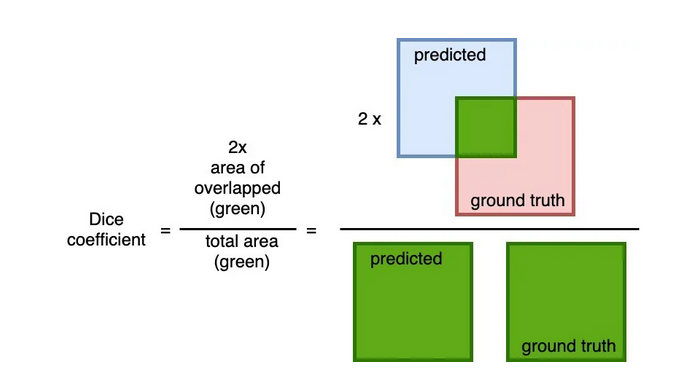
Here:

"Intersection" refers to the number of pixels that are correctly classified as part of the object in both the ground truth and prediction masks.
"Total Pixels in Ground Truth" is the total number of pixels labeled as part of the object in the ground truth mask.
"Total Pixels in Prediction" is the total number of pixels labeled as part of the object in the prediction mask.
The Dice coefficient ranges from 0 to 1, where a value of 0 indicates no overlap between the predicted and ground truth masks (no agreement), and a value of 1 indicates perfect overlap (perfect agreement). Higher Dice coefficients indicate better segmentation accuracy.

In the context of machine learning and deep learning, the Dice coefficient is often used as a loss function (called the Dice loss) to train models for image segmentation tasks. The goal is to maximize the Dice coefficient, which encourages the model to produce segmentation masks that closely match the ground truth masks.

`dice_coef(y_true, y_pred):`

This function calculates the Dice coefficient between the ground truth mask (y_true) and the predicted mask (y_pred) for binary image segmentation. The Dice coefficient is a measure of the overlap between two sets. It's commonly used to evaluate the similarity between the predicted and true segmentations.
The function first flattens both y_true and y_pred using K.flatten() from the Keras backend. Then, it calculates the intersection between the flattened masks using element-wise multiplication and sums them using K.sum().
The Dice coefficient is computed as (2 * intersection + smooth) / (sum of true mask + sum of predicted mask + smooth), where smooth is a constant to avoid division by zero.

`dice_coef_loss(y_true, y_pred):`

This function computes the negative Dice coefficient loss. It's used as a loss function for training the neural network. The goal is to minimize this loss to improve the Dice coefficient during training.
It calls the dice_coef() function to calculate the Dice coefficient and returns its negative value.



> A loss function, also known as a cost function or objective function, is a mathematical function used to quantify the difference between the predicted values generated by a machine learning model and the actual target values in a dataset. The goal of a machine learning algorithm is to minimize this loss function during the training process.




`iou(y_true, y_pred):`

This function calculates the Intersection over Union (IoU) metric between the ground truth mask (y_true) and the predicted mask (y_pred) for binary image segmentation.
It computes the intersection between the masks and the sum of their union. The IoU is then calculated as (intersection + smooth) / (union - intersection + smooth).



> In the context of binary image segmentation:

True Positive (TP): The pixels that are correctly predicted as part of the object in both the predicted mask (y_pred) and the ground truth mask (y_true).

False Positive (FP): The pixels that are incorrectly predicted as part of the object in the predicted mask (y_pred), but not in the ground truth mask (y_true).

False Negative (FN): The pixels that are part of the object in the ground truth mask (y_true), but not correctly predicted as such in the predicted mask (y_pred). *italicized text*

Using these definitions, the IoU is calculated as follows:

**IoU = TP / (TP + FP + FN)**

Alternatively, the IoU can be calculated using the following formula, which is equivalent:

IoU = Intersection Area / (Area of Ground Truth Mask + Area of Predicted Mask - Intersection Area)

The IoU metric ranges from 0 to 1, with higher values indicating better segmentation performance. An IoU of 1 indicates a perfect overlap between the predicted and ground truth masks, while an IoU of 0 indicates no overlap at all.

IoU is a useful metric for evaluating segmentation algorithms because it considers both false positives and false negatives. It rewards accurate localization and penalizes both under-segmentation and over-segmentation of the object of interest.



`jac_distance(y_true, y_pred):`

This function calculates the Jaccard distance metric between the ground truth mask (y_true) and the predicted mask (y_pred) for binary image segmentation.
It computes the Jaccard distance as the negative IoU.




> The Jaccard distance, also known as the Jaccard dissimilarity coefficient, is a metric used to measure the dissimilarity or dissimilarity between two sets. It's complementary to the Jaccard similarity coefficient (also known as the Intersection over Union or IoU), which measures the similarity between two sets.
In the context of binary image segmentation, the Jaccard distance can be used as a metric to evaluate how dissimilar the predicted mask (y_pred) and the ground truth mask (y_true) are. It's calculated as:

>**Jaccard Distance = 1 - Jaccard Index**
>Where the Jaccard Index is calculated as:
>**Jaccard Index = Intersection of Predicted Mask and Ground Truth Mask / Union of Predicted Mask and Ground Truth Mask**

>The Jaccard distance ranges from 0 to 1, with 0 indicating perfect similarity (the masks are identical) and 1 indicating complete dissimilarity (the masks have no overlapping pixels).
The Jaccard distance is often used as a complementary metric to the Jaccard similarity coefficient. While the Jaccard similarity coefficient quantifies how similar two sets are, the Jaccard distance quantifies how dissimilar they are. In the context of image segmentation, a smaller Jaccard distance indicates better segmentation performance, as it implies that the predicted mask is closer to the ground truth mask.



In [10]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# 8. Unet Model

The U-Net is a popular architecture for semantic segmentation tasks, particularly in the field of medical image analysis. It was introduced in the paper titled "U-Net: Convolutional Networks for Biomedical Image Segmentation" by Olaf Ronneberger, Philipp Fischer, and Thomas Brox.

The U-Net architecture is designed for pixel-wise segmentation tasks, where the goal is to classify each pixel in an input image into one or more classes. It has an encoder-decoder structure with skip connections, which helps it capture both local and global context while maintaining fine-grained spatial information.

Here's a high-level overview of the U-Net architecture:

Encoder: The encoder is composed of convolutional and pooling layers that progressively reduce the spatial dimensions of the input image while increasing the number of feature channels. This helps the network learn abstract and high-level features.

Bottleneck: At the bottom of the architecture, there's a bottleneck layer that captures the most abstract representation of the input.

Decoder: The decoder is composed of transposed convolutional layers (also known as upsampling or deconvolutional layers) that progressively increase the spatial dimensions of the feature map while reducing the number of feature channels. This helps recover spatial information.

Skip Connections: The skip connections are connections between the encoder and decoder layers at the same spatial resolution. These connections allow the decoder to access both high-level semantic information from the encoder and fine-grained spatial information from the skip connections. This aids in preserving details during upsampling.

The U-Net architecture is widely used for various image segmentation tasks, especially in medical image analysis. It has proven effective due to its ability to learn from limited labeled data and its capacity to produce accurate and detailed segmentation results.

The U-Net architecture can be customized with variations such as different numbers of layers, skip connection strategies, and additional components like batch normalization and dropout. It's a versatile framework that has been extended and adapted to suit different segmentation challenges.

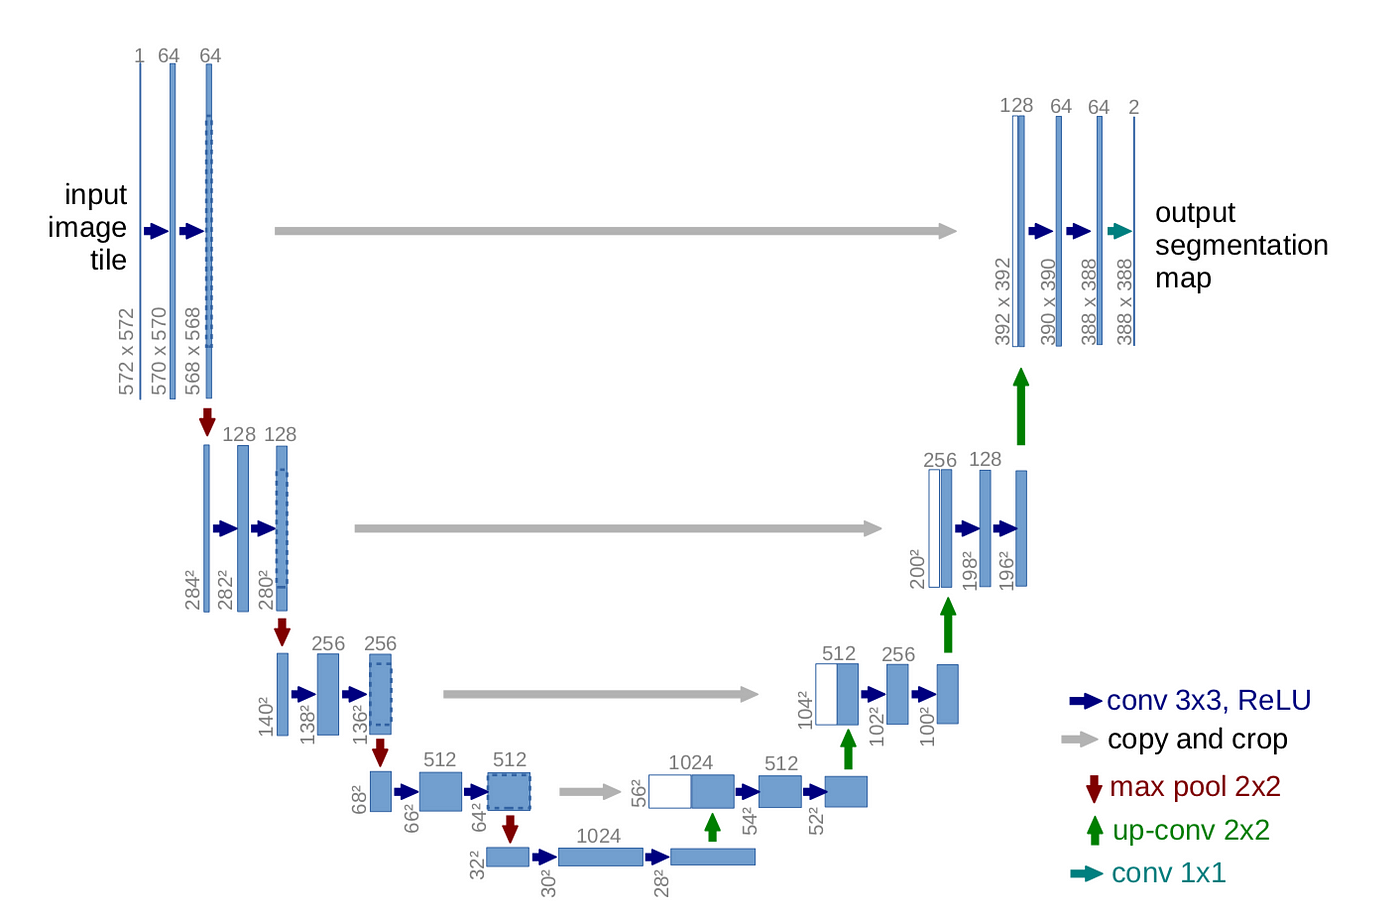

In [11]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [12]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# 9. Training the model

### Setting Hyperparameters:

In [13]:
epochs =100
batch_size = 32
learning_rate =  1e-4

### Data Augmentation, Preparation, Model compilation, Callbacks

In [14]:
#A dictionary specifying data augmentation parameters such as rotation range, width and height shift range, shear range, zoom range, and fill mode.

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range = 0.05,
                            height_shift_range = 0.05,
                            shear_range = 0.05,
                            zoom_range=0.05,
                            fill_mode= 'nearest')

#Generating augmented training images and masks using the train_generator function.
#This function generates batches of images and masks with data augmentation applied.
train_gen = train_generator(df_train, batch_size,
                            train_generator_args,
                            target_size=(img_height, img_width))

#Generating batches of validation images and masks using the train_generator function without augmentation.
test_gener = train_generator(df_val, batch_size,
                             dict(),
                             target_size=(img_height, img_width))

#Creating a U-Net model
model= unet(input_size= (img_height, img_height ,3))

#Compiling the model with the Adam optimizer using the specified learning rate,
#dice_coef_loss as the loss function, and several metrics including binary accuracy, IoU, and dice coefficient.
opt = Adam(lr=learning_rate, beta_1 =0.9, beta_2 = 0.999, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=['binary_accuracy', iou, dice_coef])

#Creating a list of callbacks. In this case, using the ModelCheckpoint callback to save the best model weights during training.
callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

#Training the Model
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train)/batch_size,
                    epochs = epochs,
                    callbacks= callbacks,
                    validation_data = test_gener,
                    validation_steps =len(df_val)/batch_size)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
89/88 [==============================] - ETA: -1s - loss: -0.2238 - binary_accuracy: 0.9563 - iou: 0.1342 - dice_coef: 0.2264Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.03175, saving model to unet_brain_mri_seg.hdf5
88/88 [==============================] - 229s 2s/step - loss: -0.2238 - binary_accuracy: 0.9563 - iou: 0.1342 - dice_coef: 0.2264 - val_loss: -0.0318 - val_binary_accuracy: 0.9908 - val_iou: 0.0161 - val_dice_coef: 0.0312
Epoch 2/100
89/88 [==============================] - ETA: 0s - loss: -0.4738 - binary_accuracy: 0.9897 - iou: 0.3211 - dice_coef: 0.4752
Epoch 2: val_loss improved from -0.03175 to -0.34284, saving model to unet_brain_mri_seg.hdf5
88/88 [==============================] - 139s 2s/step - loss: -0.4738 - binary_accuracy: 0.9897 - iou: 0.3211 - dice_coef: 0.4752 - val_loss: -0.3428 - val_binary_accurac



---


### We get a final loss of -0.8901, binary accuracy of 0.9979, Intersection of union 0.805, and dice coefficient of 0.8893 on the training set.


### on the validation dataset- we get a loss of -0.9796,  validation binary accuracy of 0.9978, validation Intersection of union is 0.7913, dice coeffient on validation dataset of 0.8818

# 10. Visualising

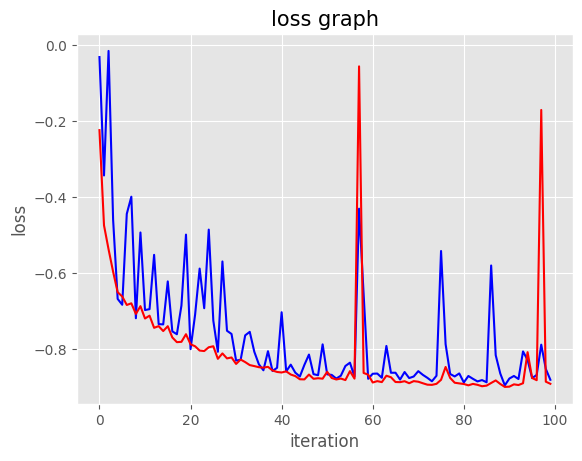

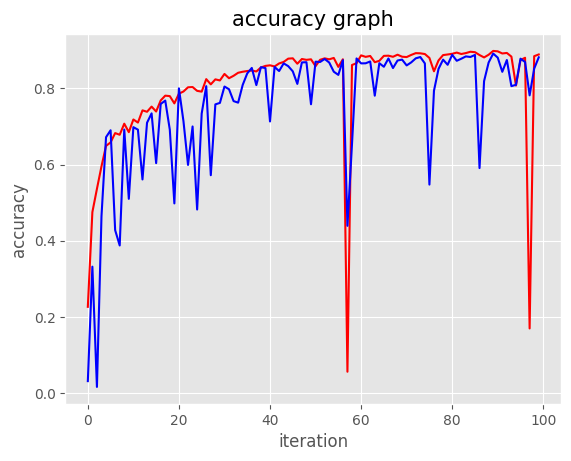

In [15]:
h = history.history

list_traindice = h['dice_coef']
list_testdice = h['val_dice_coef']

list_trainjaccard = h['iou']
list_testjaccard = h['val_iou']

list_trainloss = h['loss']
list_testloss = h['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)

plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

It is evident that the loss decreases while the accuracy increases.

# 11. loading a trained U-Net model from a saved HDF5 file

In [16]:
model = load_model('unet_brain_mri_seg.hdf5',custom_objects ={'dice_coef_loss':dice_coef_loss,
                                                             'iou': iou,
                                                              'dice_coef': dice_coef})

# 12. Running the model on test images

In [18]:
test_gen = train_generator(df_test, batch_size, dict(), target_size =(img_height, img_width))
results = model.evaluate(test_gen, steps=len(df_test)/batch_size)
print('test lost : ', results[0])
print('test IOU : ', results[1])
print('test Dice Coefficient : ', results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 12s 921ms/step - loss: -0.8473 - binary_accuracy: 0.9974 - iou: 0.7445 - dice_coef: 0.8502
test lost :  -0.8473007678985596
test IOU :  0.9973596334457397
test Dice Coefficient :  0.7445089817047119


1/1 [==============================] - 2s 2s/step


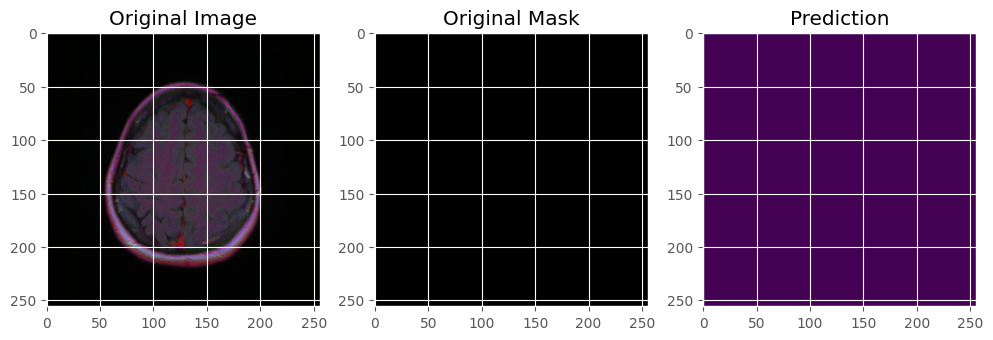

1/1 [==============================] - 0s 24ms/step


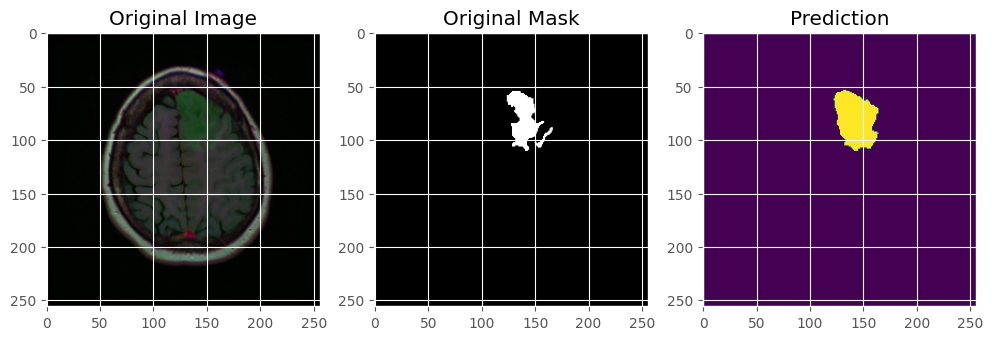

1/1 [==============================] - 0s 24ms/step


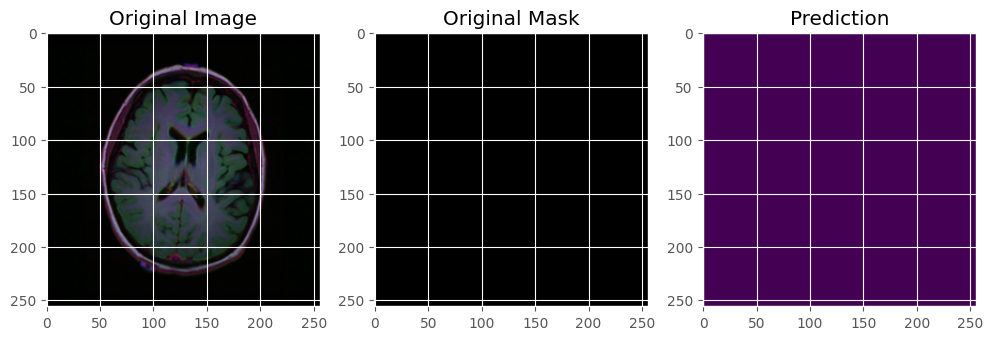

1/1 [==============================] - 0s 23ms/step


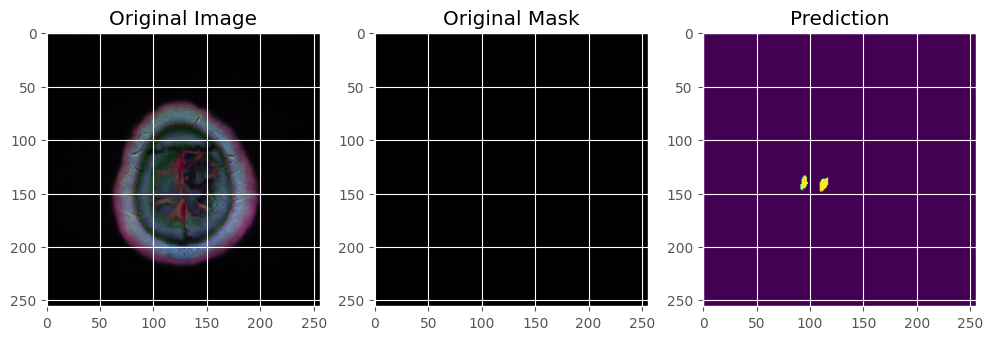

1/1 [==============================] - 0s 42ms/step


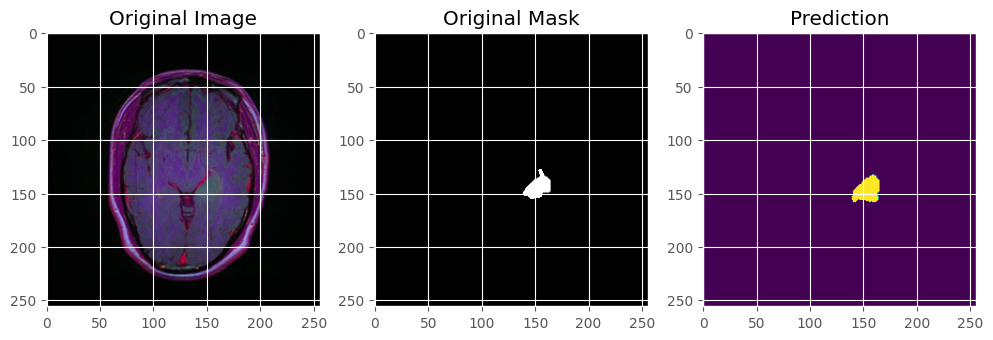

1/1 [==============================] - 0s 34ms/step


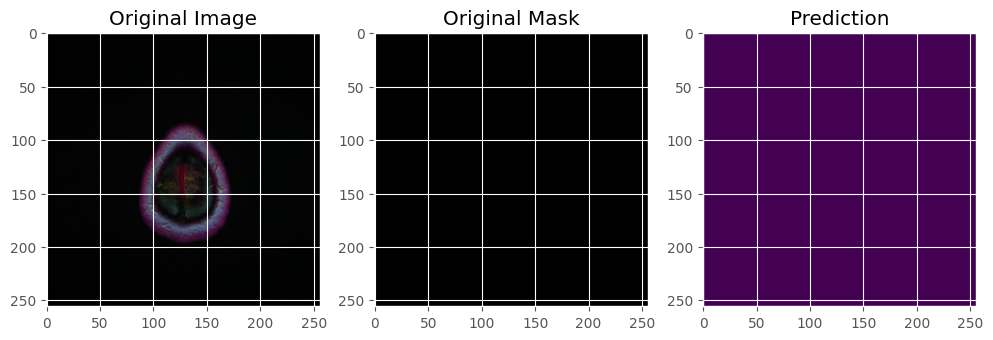

1/1 [==============================] - 0s 24ms/step


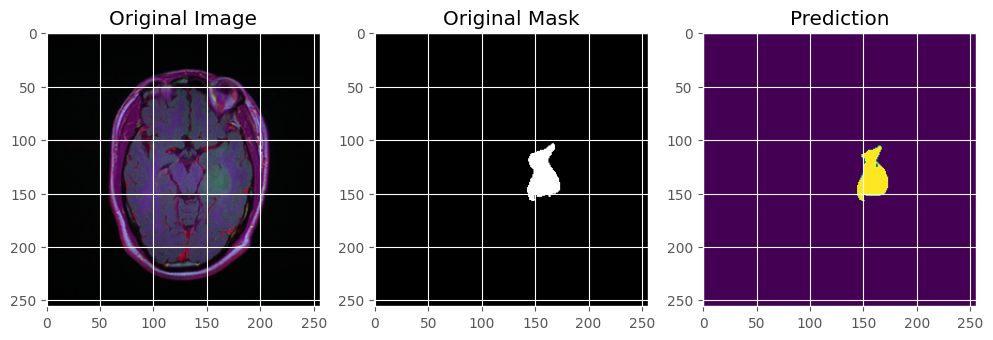

1/1 [==============================] - 0s 26ms/step


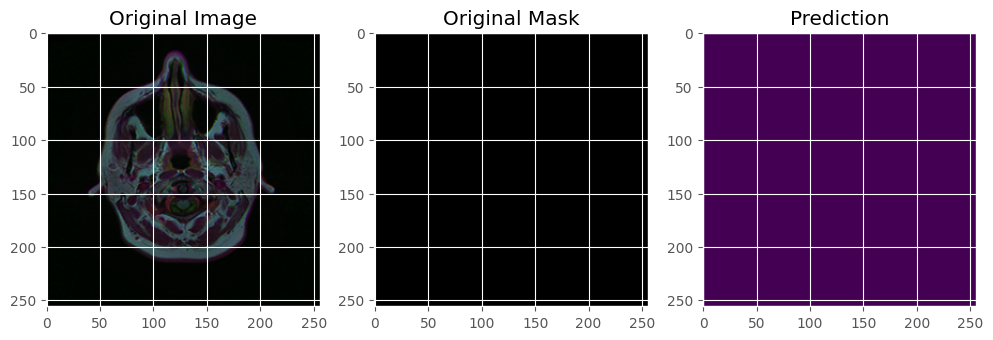

1/1 [==============================] - 0s 26ms/step


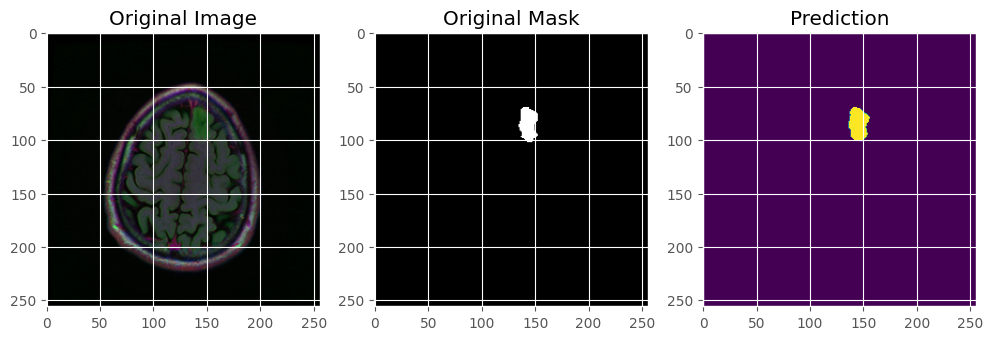

1/1 [==============================] - 0s 24ms/step


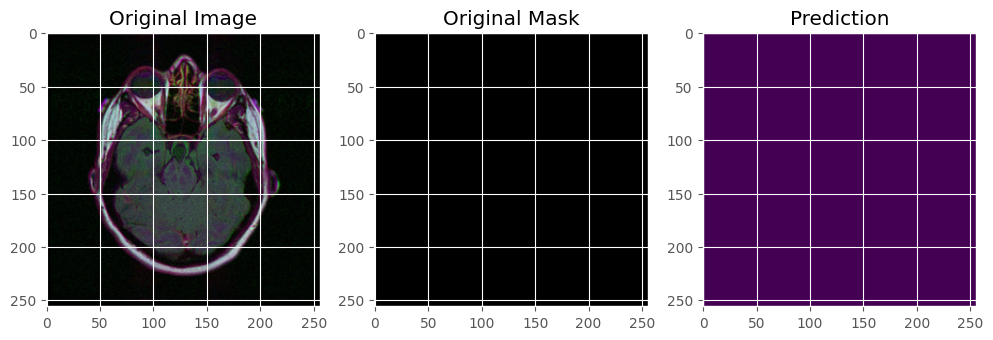

1/1 [==============================] - 0s 21ms/step


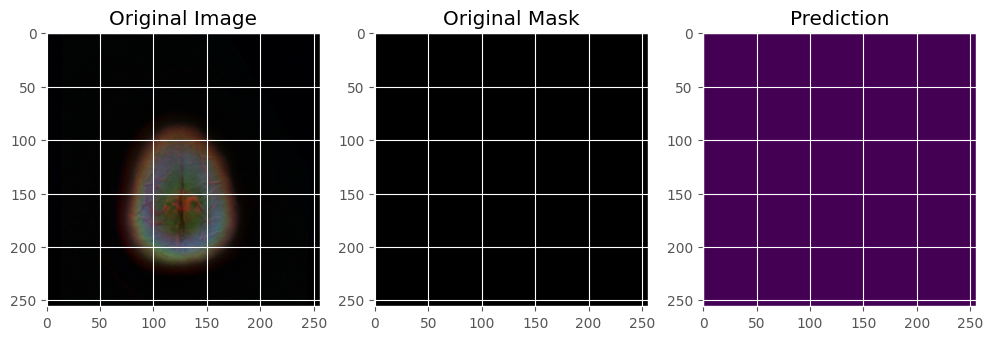

1/1 [==============================] - 0s 24ms/step


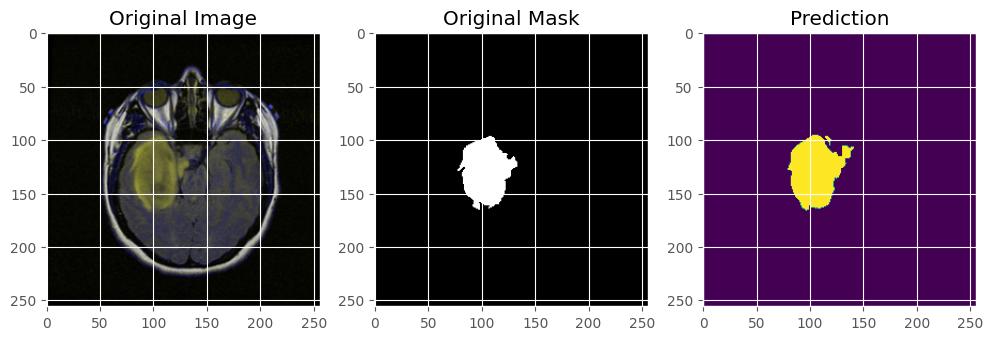

1/1 [==============================] - 0s 22ms/step


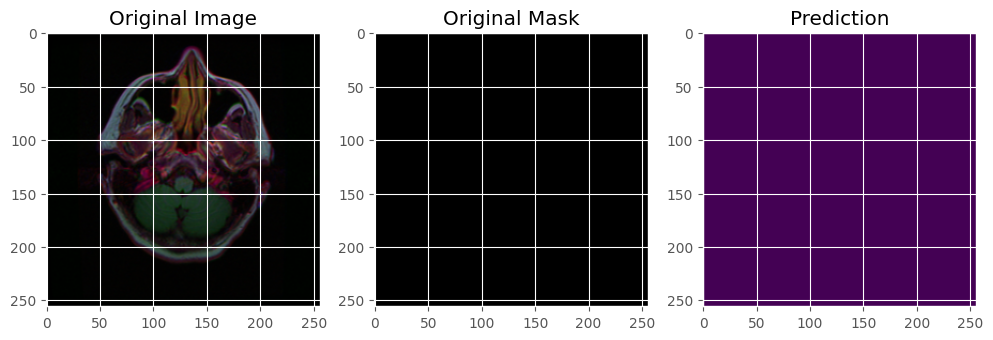

1/1 [==============================] - 0s 28ms/step


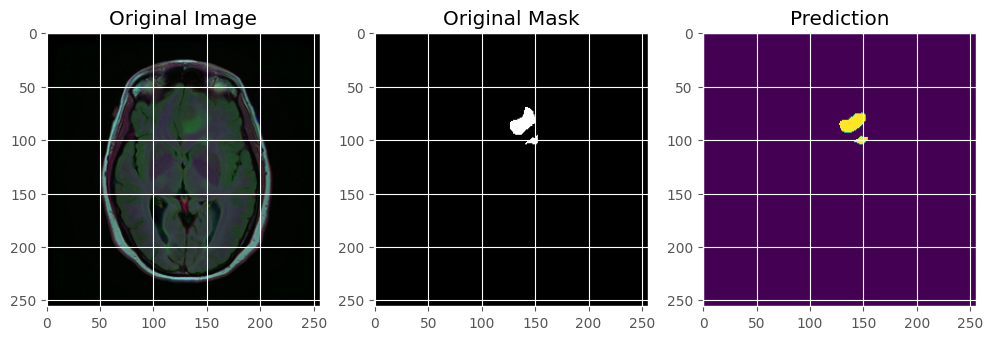

1/1 [==============================] - 0s 26ms/step


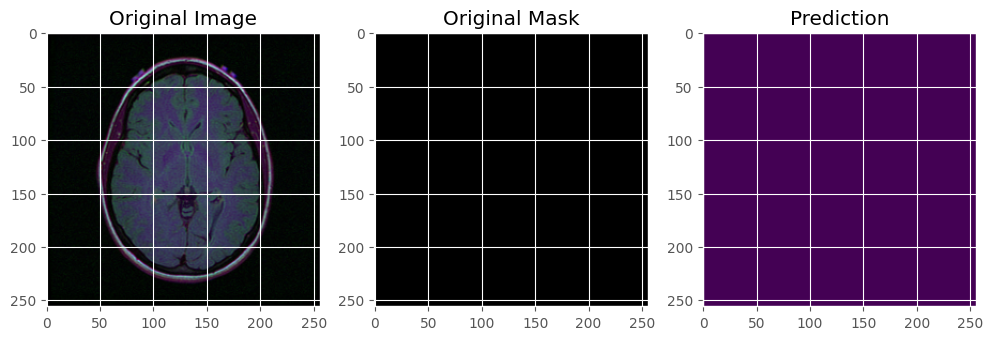

1/1 [==============================] - 0s 28ms/step


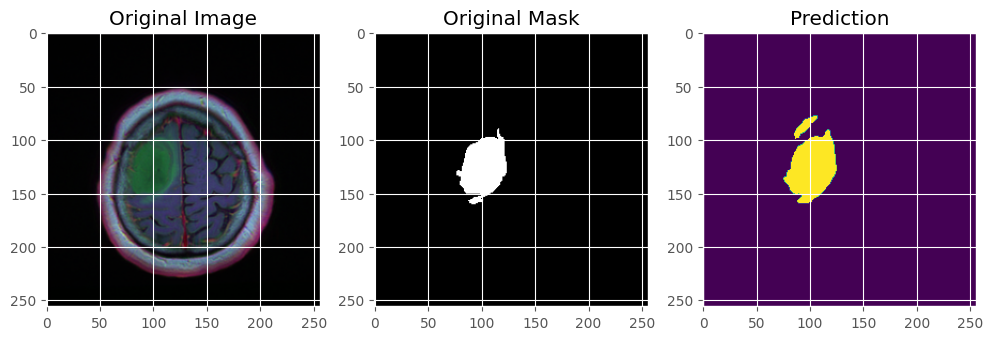

1/1 [==============================] - 0s 23ms/step


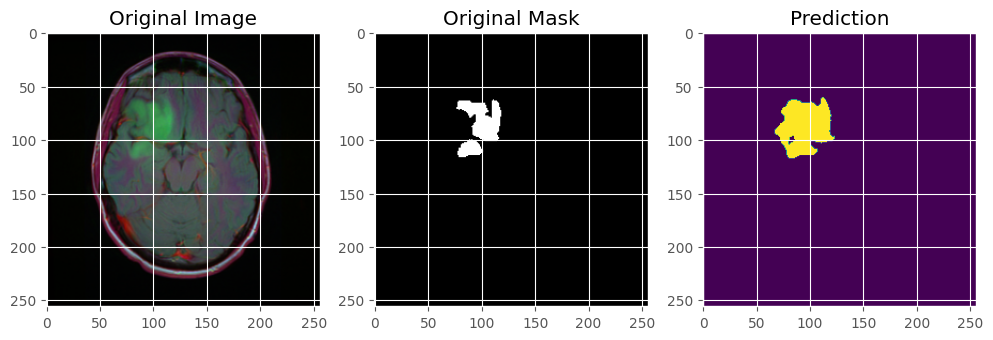

1/1 [==============================] - 0s 28ms/step


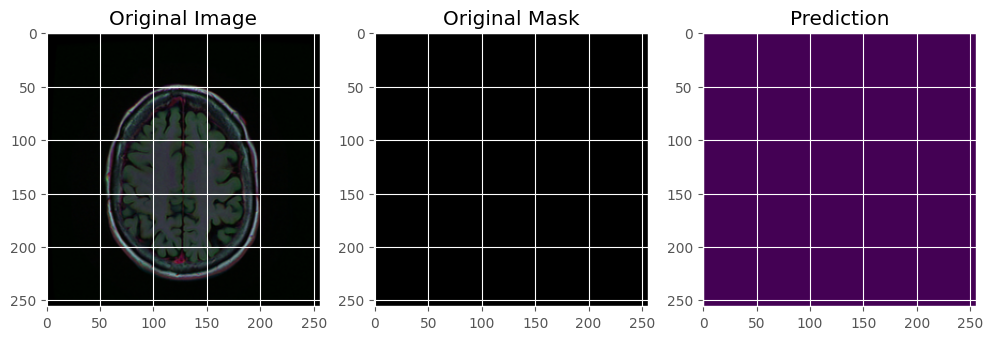

1/1 [==============================] - 0s 27ms/step


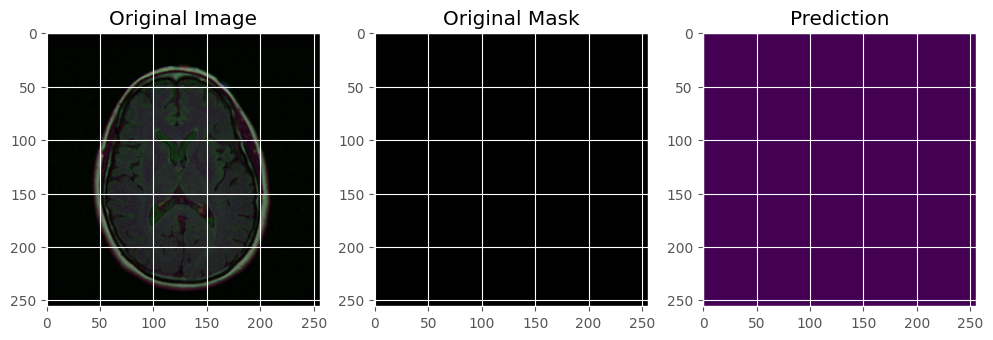

1/1 [==============================] - 0s 44ms/step


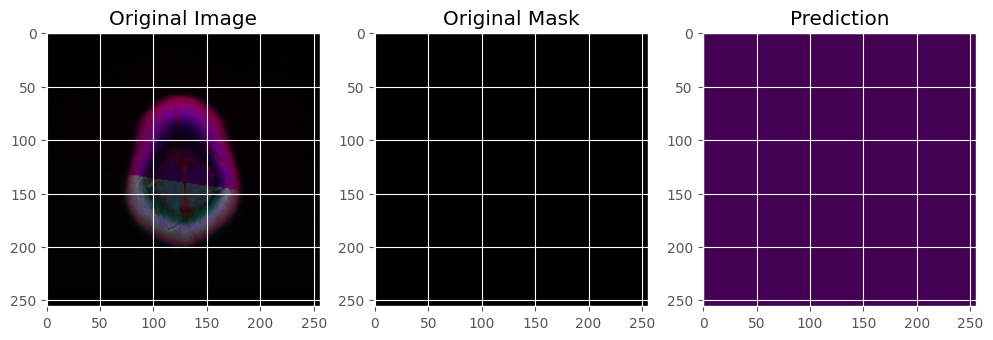

1/1 [==============================] - 0s 38ms/step


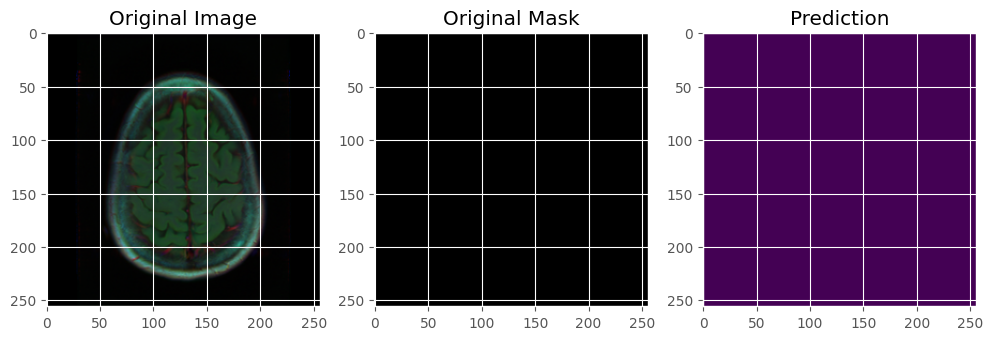

1/1 [==============================] - 0s 28ms/step


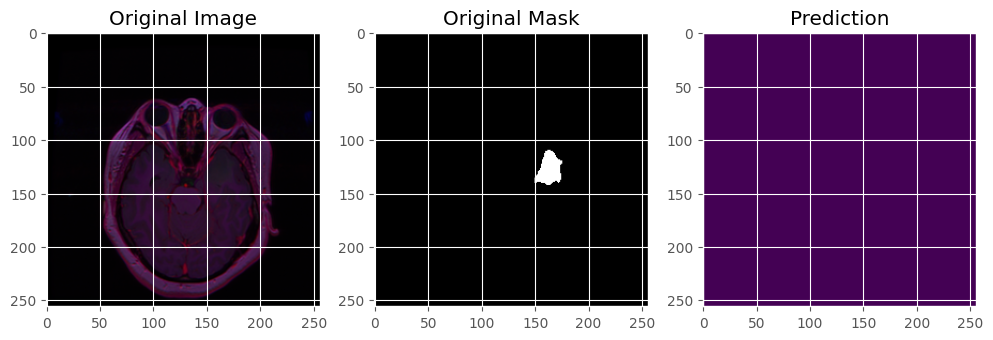

1/1 [==============================] - 0s 27ms/step


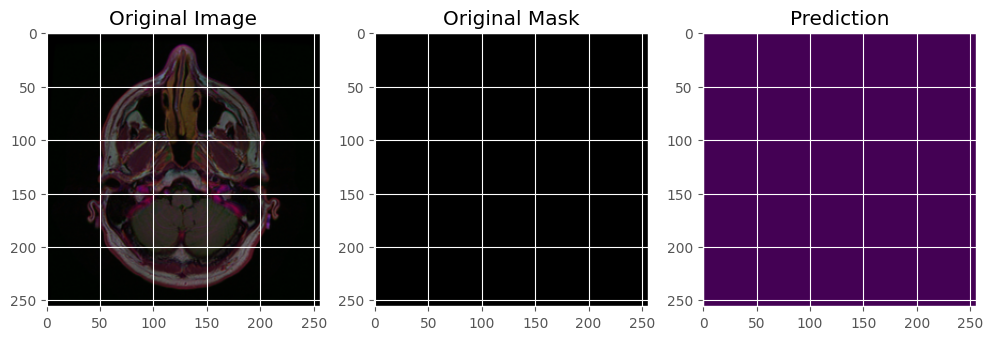

1/1 [==============================] - 0s 30ms/step


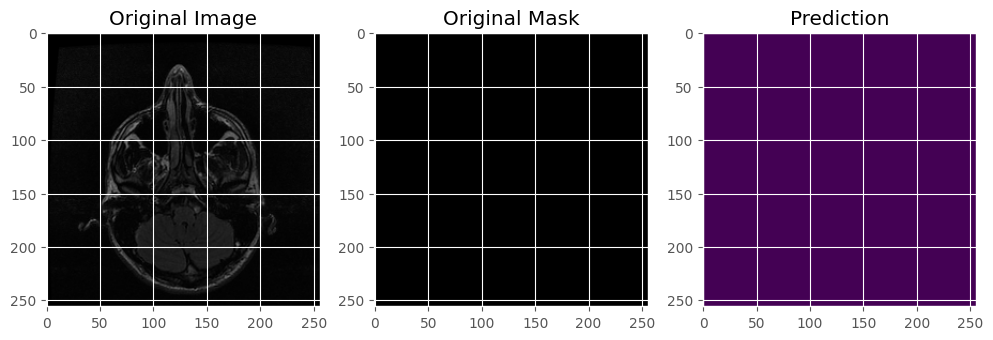

1/1 [==============================] - 0s 26ms/step


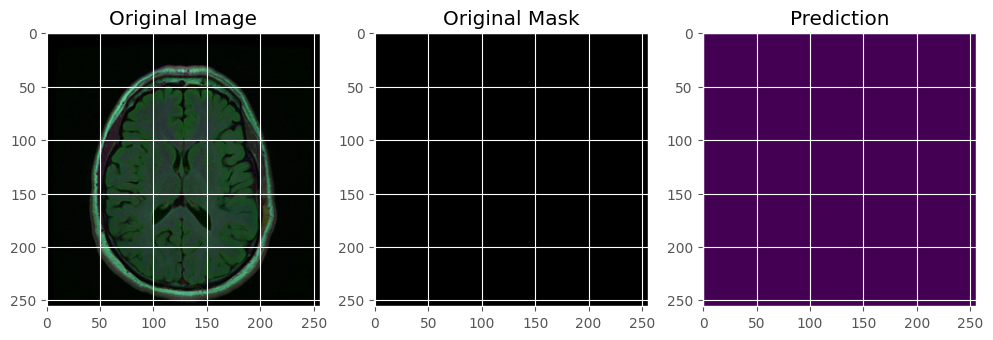

1/1 [==============================] - 0s 44ms/step


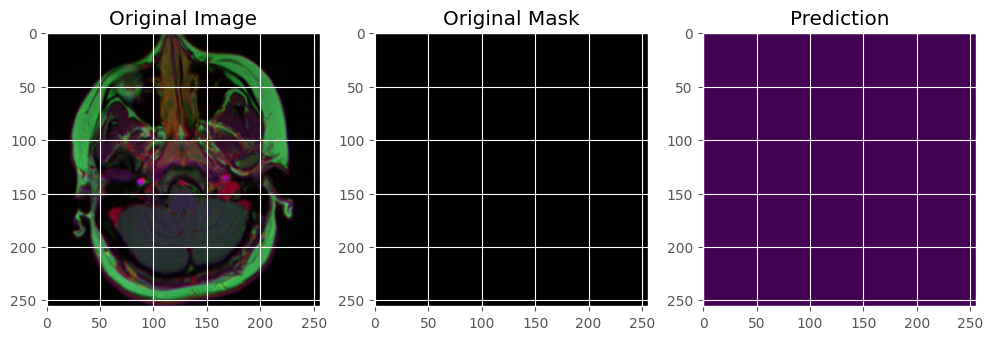

1/1 [==============================] - 0s 33ms/step


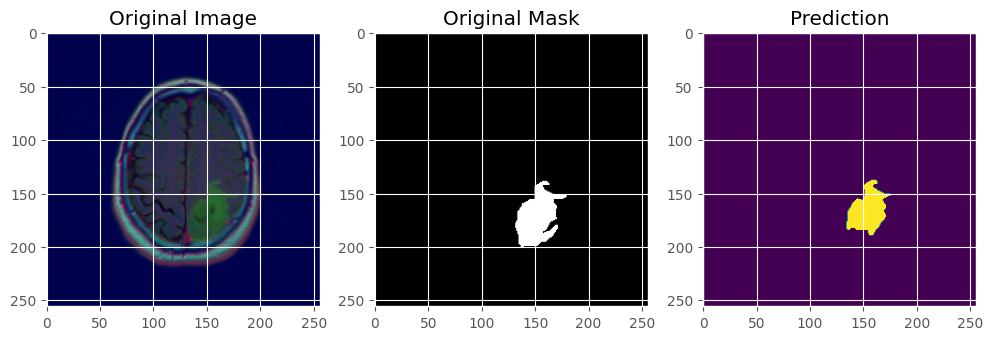

1/1 [==============================] - 0s 33ms/step


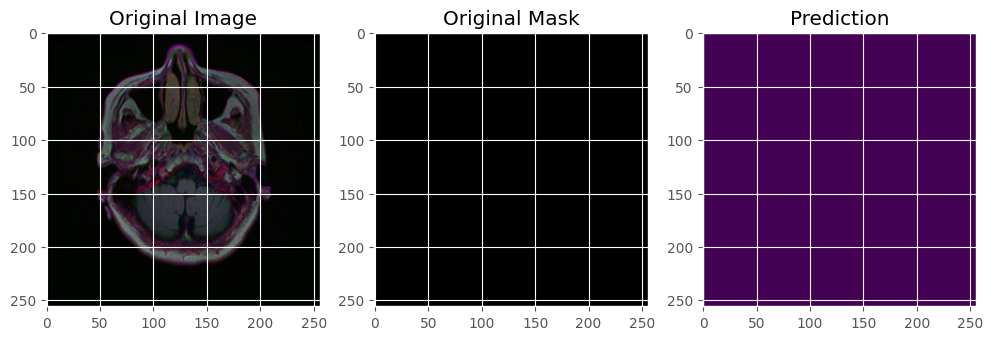

1/1 [==============================] - 0s 34ms/step


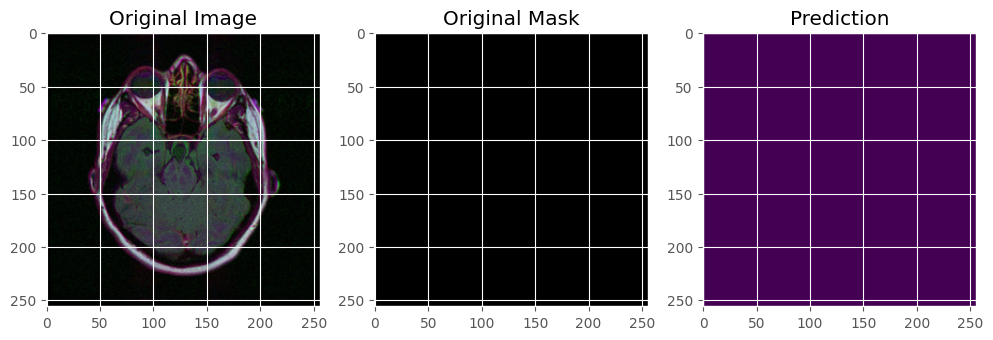

1/1 [==============================] - 0s 34ms/step


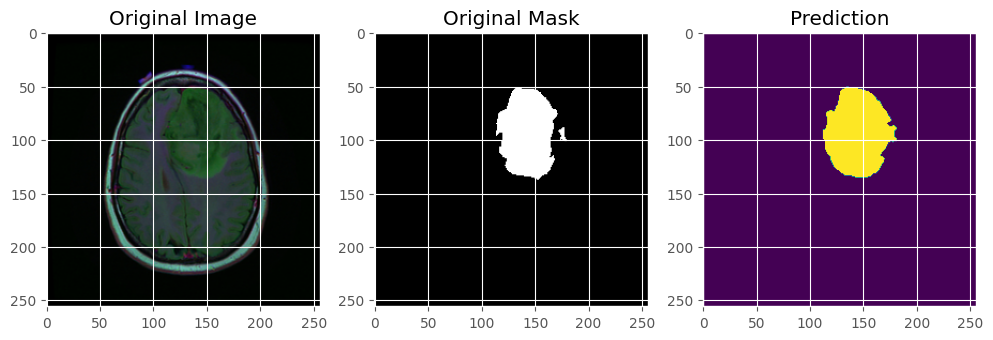

In [20]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(img_height, img_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()